# **Smarter anomaly detection** - Post-processing back-test results
*Part 3 - Results post-processing*

## Initialization
---
This repository is structured as follow:

```sh
. smarter-anomaly-detection
|
├── data/
|   ├── interim                          # Temporary intermediate data are stored here
|   ├── processed                        # Finalized datasets ready to be moved to Amazon S3
|   └── raw                              # Immutable original data are stored here
|
└── notebooks/
    ├── 1_data_preparation.ipynb
    ├── 2_model_training.ipynb
    └── 3_model_evaluation.ipynb         <<< THIS NOTEBOOK <<<
```

### Notebook configuration update

In [1]:
!pip install --quiet --upgrade lookoutequipment

### Imports

In [2]:
import boto3
import synthetic_config as config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sagemaker

from matplotlib.gridspec import GridSpec

# SDK / toolbox for managing Lookout for Equipment API calls:
import lookoutequipment as lookout

### Parameters

In [3]:
TMP_DATA       = os.path.join('..', 'data', 'interim')
PROCESSED_DATA = os.path.join('..', 'data', 'processed')
LABEL_DATA     = os.path.join(PROCESSED_DATA, 'label-data')
TRAIN_DATA     = os.path.join(PROCESSED_DATA, 'train-data', 'synthetic')

MODEL_NAME     = config.MODEL_NAME
DATASET_NAME   = config.DATASET_NAME
ROLE_ARN       = sagemaker.get_execution_role()

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams['lines.linewidth'] = 1.0

### Loading original datasets for visualization purpose

In [5]:
all_tags_fname = os.path.join(TRAIN_DATA, 'sensors.csv')
all_tags_df = pd.read_csv(all_tags_fname)
all_tags_df['Timestamp'] = pd.to_datetime(all_tags_df['Timestamp'])
all_tags_df = all_tags_df.set_index('Timestamp')

### Helper functions

In [6]:
def plot_ranges(range_df, range_title, color, ax):
    ax.plot(range_df['Label'], color=color)
    ax.fill_between(range_df.index, 
                    y1=range_df['Label'], 
                    y2=0, 
                    alpha=0.1, 
                    color=color)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel(range_title, fontsize=12)

## Extracting model back-test results
---

The [**DescribeModel**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_DescribeModel.html) API can be used to extract, among other things, the metrics associated to the trained model. Here are the different fields available when calling this API:

In [7]:
lookout_dataset = lookout.LookoutEquipmentDataset(
    dataset_name=DATASET_NAME, 
    access_role_arn=ROLE_ARN,
    component_root_dir=TRAIN_DATA
)
response = lookout_dataset.client.describe_model(ModelName=MODEL_NAME)
training_start   = pd.to_datetime(response['TrainingDataStartTime']).tz_localize(None)
training_end     = pd.to_datetime(response['TrainingDataEndTime']).tz_localize(None)
evaluation_start = pd.to_datetime(response['EvaluationDataStartTime']).tz_localize(None)
evaluation_end   = pd.to_datetime(response['EvaluationDataEndTime']).tz_localize(None)

LookoutDiagnostics = lookout.LookoutEquipmentAnalysis(model_name=MODEL_NAME, tags_df=all_tags_df)
LookoutDiagnostics.set_time_periods(evaluation_start, evaluation_end, training_start, training_end)
predicted_ranges = LookoutDiagnostics.get_predictions()
labels_fname = os.path.join(LABEL_DATA, 'synthetic-labels.csv')
labeled_range = LookoutDiagnostics.get_labels(labels_fname)

## Visualizing anomaly detection model results
---

Let's now display one of the original signal and map both the labeled and the predicted ranges on the same plot:

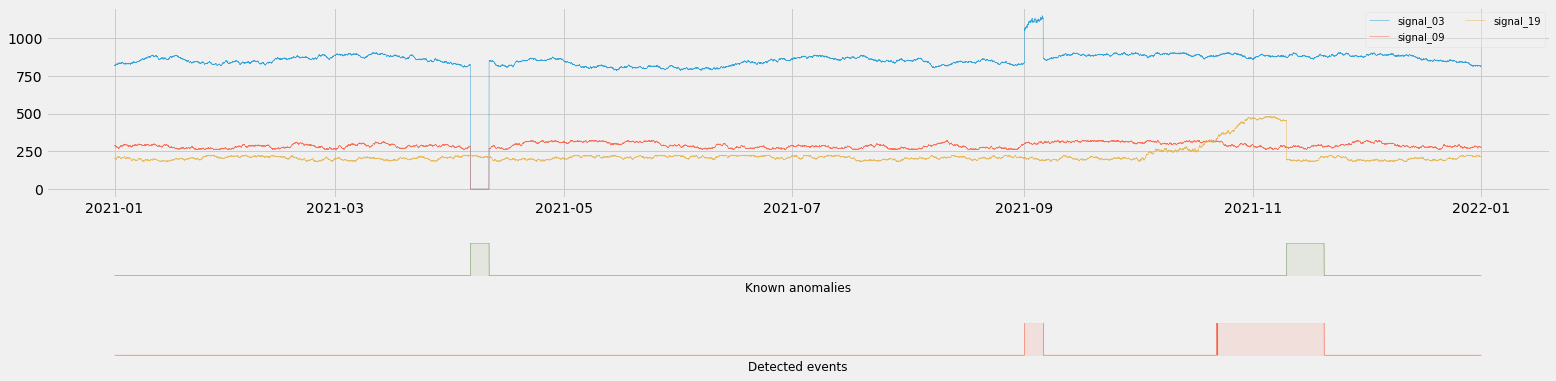

In [8]:
tags_list = list(all_tags_df.columns)
custom_colors = {
    'labels': colors[3],
    'predictions': colors[1]
}
    
TSViz = lookout.plot.TimeSeriesVisualization(
    timeseries_df=all_tags_df,
    data_format='tabular'
)
TSViz.add_signal([tags_list[3], tags_list[9], tags_list[19]])
TSViz.add_labels(labeled_range)
TSViz.add_predictions([predicted_ranges])
# TSViz.add_train_test_split(evaluation_start)
TSViz.legend_format = {
    'loc': 'upper right',
    'framealpha': 0.4,
    'ncol': 2
}
fig, axis = TSViz.plot(fig_width=24, colors=custom_colors)

Let's zoom on the second part (the big event and some of the spikes happening afterward):

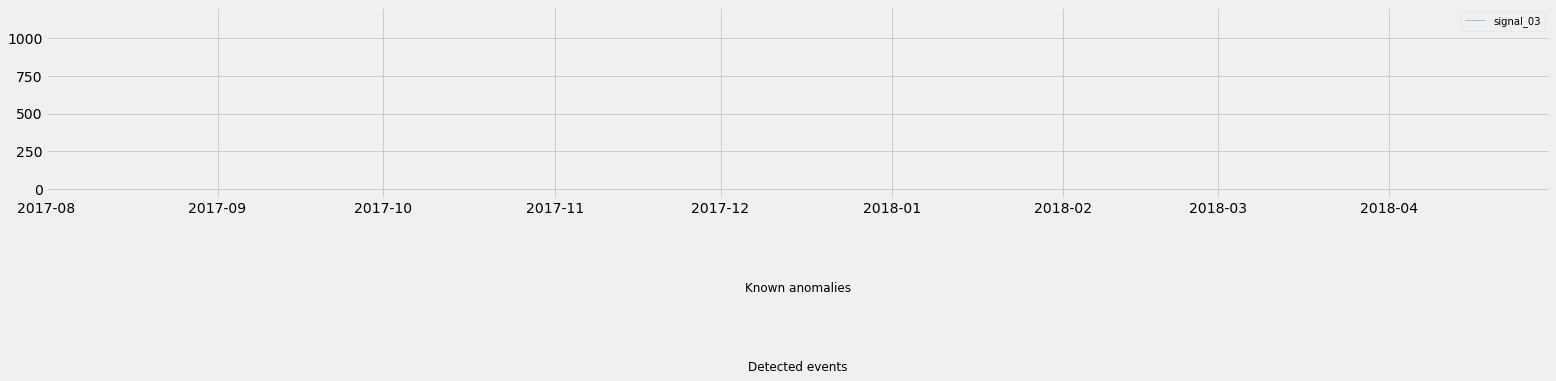

In [9]:
TSViz = lookout.plot.TimeSeriesVisualization(
    timeseries_df=all_tags_df,
    data_format='tabular'
)
TSViz.add_signal([tags_list[3]])
TSViz.add_labels(labeled_range)
TSViz.add_predictions([predicted_ranges])
TSViz.legend_format = {
    'loc': 'upper right',
    'framealpha': 0.4,
    'ncol': 2
}

fig, axis = TSViz.plot(fig_width=24, colors=custom_colors)
for ax in axis:
    ax.set_xlim(pd.to_datetime('2017-08-01'), pd.to_datetime('2018-04-30'))

The events are provided as ranges: to further post-process the results, we will need an expanded dataframe where each timestamp is marked as normal or abnormal:

In [10]:
predicted_ranges['duration'] = pd.to_datetime(predicted_ranges['end']) - pd.to_datetime(predicted_ranges['start'])
predicted_ranges['duration'] = predicted_ranges['duration'].dt.total_seconds() / 3600
predictions_df = TSViz._convert_ranges(predicted_ranges, default_freq='5min')
predicted_ranges

,start,end,diagnostics,duration
0,2021-09-01 00:30:00,2021-09-06 00:40:00,"[{'name': 'synthetic\signal_00', 'value': 0.02...",120.166667
1,2021-10-22 07:30:00,2021-10-22 10:40:00,"[{'name': 'synthetic\signal_00', 'value': 0.03...",3.166667
2,2021-10-22 14:00:00,2021-11-20 00:40:00,"[{'name': 'synthetic\signal_00', 'value': 0.07...",682.666667


Let's now expand the results to have one sensor per column in a dataframe:

In [11]:
expanded_results = []
for index, row in predicted_ranges.iterrows():
    new_row = dict()
    new_row.update({'start': row['start']})
    new_row.update({'end': row['end']})
    new_row.update({'prediction': 1.0})
    
    diagnostics = pd.DataFrame(row['diagnostics'])
    diagnostics = dict(zip(diagnostics['name'], diagnostics['value']))
    new_row = {**new_row, **diagnostics}
        
    expanded_results.append(new_row)
    
expanded_results = pd.DataFrame(expanded_results)

df_list = []
for index, row in expanded_results.iterrows():
    new_index = pd.date_range(start=row['start'], end=row['end'], freq='5T')
    new_df = pd.DataFrame(index=new_index)
    
    for tag in [t for t in tags_list]:
        new_df[tag] = row[f'synthetic\\{tag}']
        
    df_list.append(new_df)
    
expanded_results_v2 = pd.concat(df_list, axis='index')
expanded_results_v2 = expanded_results_v2.reindex(predictions_df.index)

freq = '1D'
expanded_results_v3 = expanded_results_v2.resample(freq).mean()
expanded_results_v3 = expanded_results_v3.replace(to_replace=np.nan, value=0.0)

## Results post-processing
---
### Measuring event rates

In [12]:
plot_start = evaluation_start
plot_end = evaluation_end

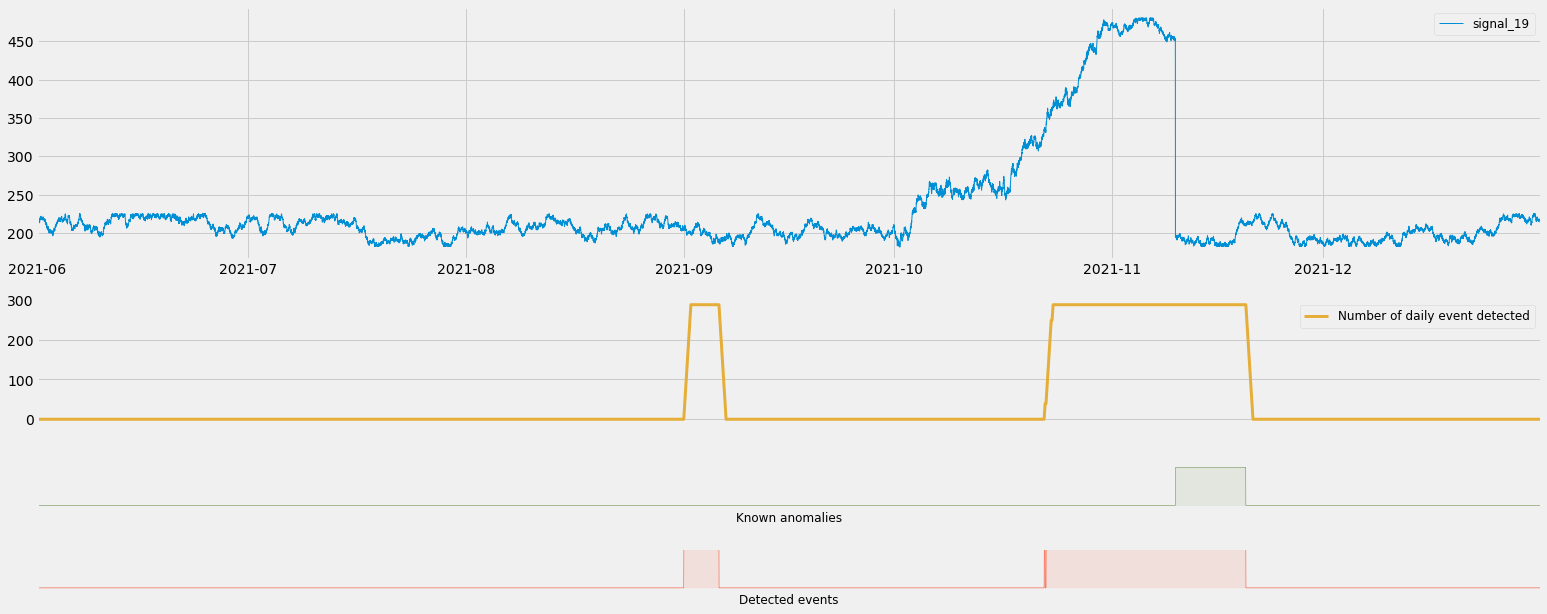

In [13]:
signal = 'signal_19'
fig = plt.figure(figsize=(24,10))
gs = GridSpec(nrows=4, ncols=1, height_ratios=[0.6, 0.3, 0.1, 0.1], hspace=0.35)
df = expanded_results_v3.loc[plot_start:plot_end, :].copy()

ax0 = fig.add_subplot(gs[0])
ax0.plot(all_tags_df.loc[plot_start:plot_end, signal], color=colors[0], linewidth=1.0, label=signal)
ax0.legend(loc='upper right', fontsize=12)
ax0.set_xlim((plot_start, plot_end))

ax1 = fig.add_subplot(gs[1])
ax1.plot(predictions_df.rolling(12*24).sum(), label='Number of daily event detected', linewidth=3.0, color=colors[2])
ax1.legend(loc='upper right', fontsize=12)
ax1.set_xlim((plot_start, plot_end))
ax1.axes.get_xaxis().set_ticks([])

ax3 = fig.add_subplot(gs[2])
labels_df = TSViz._convert_ranges(labeled_range, default_freq='5min')
plot_ranges(labels_df, 'Known anomalies', colors[3], ax3)
ax3.set_xlim((plot_start, plot_end))

ax3 = fig.add_subplot(gs[3])
plot_ranges(predictions_df, 'Detected events', colors[1], ax3)
ax3.set_xlim((plot_start, plot_end))

plt.show()

### Measuring and plotting variables contributions

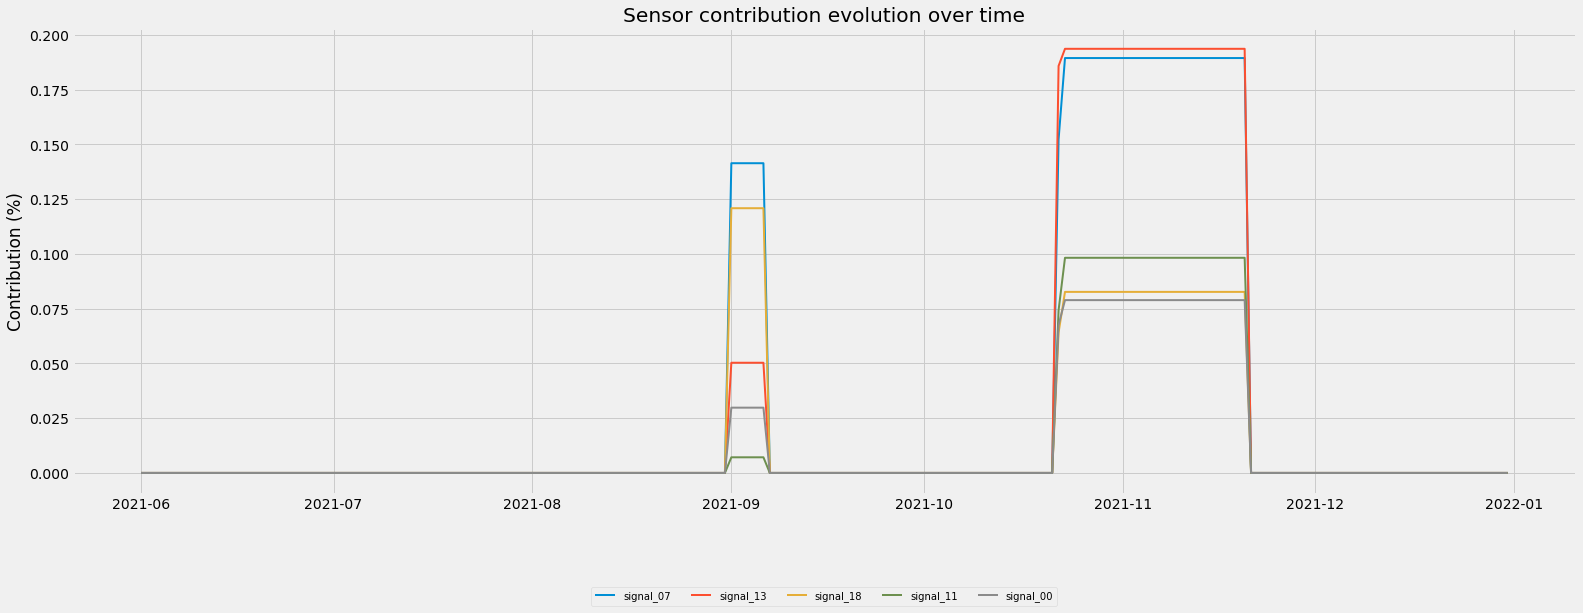

In [14]:
num_top_signals = 5
current_tags_list = list(df.sum().sort_values(ascending=False).head(num_top_signals).index)

fig = plt.figure(figsize=(24,8))
for tag in current_tags_list:
    plt.plot(df[tag], linewidth=2.0, label=tag)

plt.ylabel('Contribution (%)')
plt.title('Sensor contribution evolution over time')
plt.legend(loc='lower center', ncol=14, bbox_to_anchor=(0.5, -0.25))
plt.show()

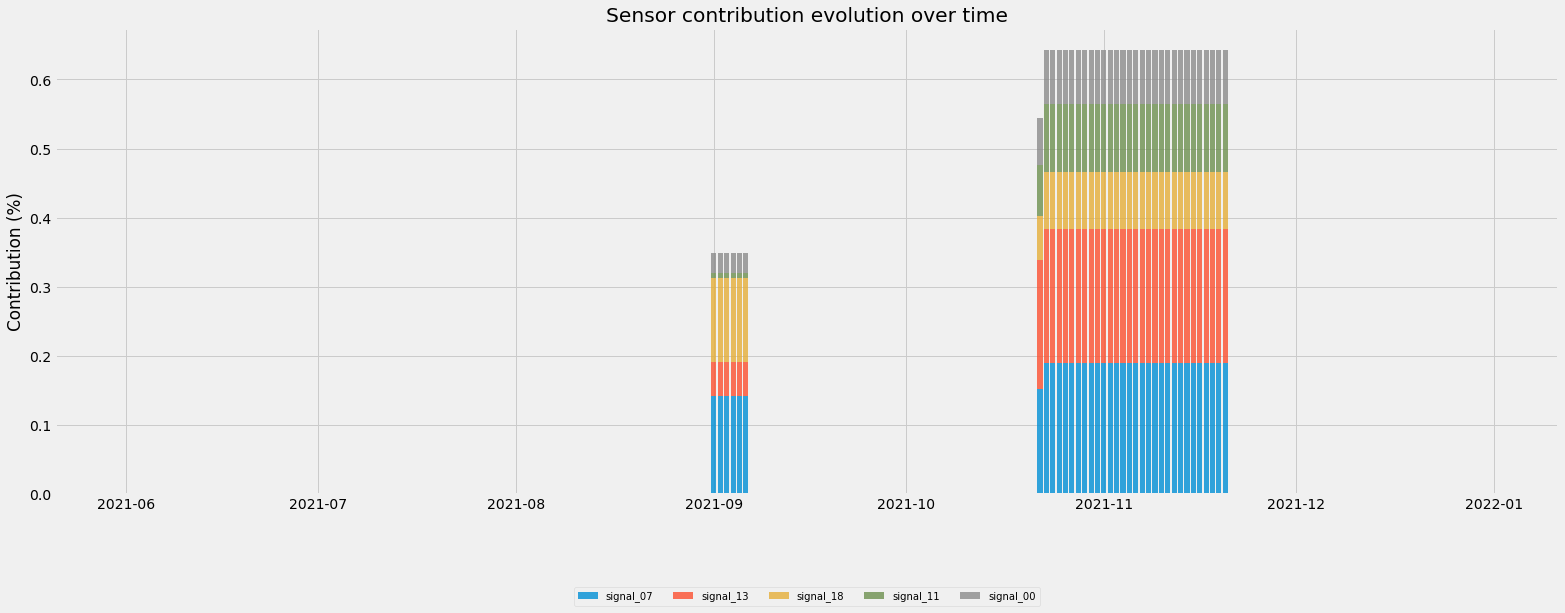

In [15]:
fig = plt.figure(figsize=(24,8))
bar_width = 0.8
bottom_values = np.zeros((len(df.index),))
for tag in current_tags_list:
    plt.bar(x=df.index, height=df[tag], bottom=bottom_values, alpha=0.8, width=bar_width, label=tag.split('\\')[0])
    bottom_values += df[tag].values

plt.ylabel('Contribution (%)')
plt.title('Sensor contribution evolution over time')
plt.legend(loc='lower center', ncol=14, bbox_to_anchor=(0.5, -0.25))
plt.show()

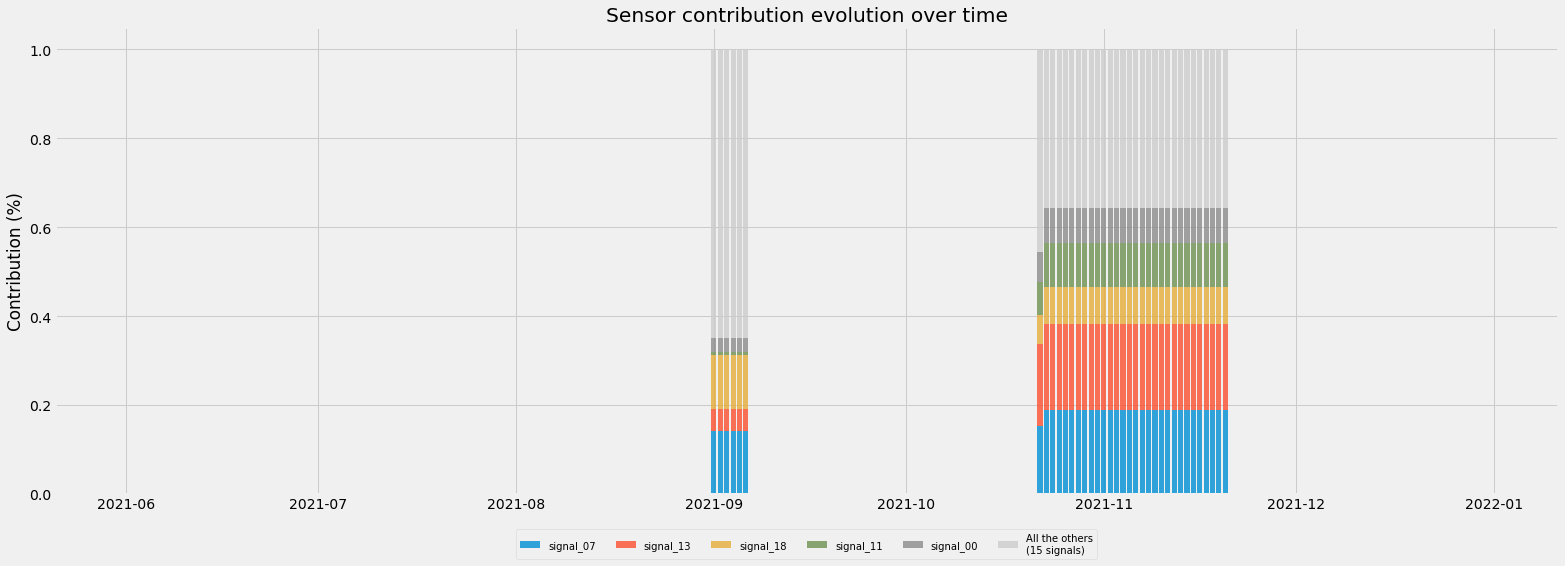

In [16]:
fig = plt.figure(figsize=(24,8))
num_top_signals = 5
bottom_values = np.zeros((len(df.index),))
current_tags_list = list(df.sum().sort_values(ascending=False).head(num_top_signals).index)
for tag in current_tags_list:
    plt.bar(x=df.index, height=df[tag], bottom=bottom_values, alpha=0.8, width=bar_width, label=tag.split('\\')[0])
    bottom_values += df[tag].values

all_other_tags = [t for t in df.columns if t not in current_tags_list]
all_other_tags_contrib = df[all_other_tags].sum(axis='columns')
plt.bar(x=df.index, height=all_other_tags_contrib, bottom=bottom_values, alpha=0.8, width=bar_width, label=f'All the others\n({len(all_other_tags)} signals)', color='#CCCCCC')

plt.ylabel('Contribution (%)')
plt.title('Sensor contribution evolution over time')
plt.legend(loc='lower center', ncol=14, bbox_to_anchor=(0.5, -0.15))
plt.show()

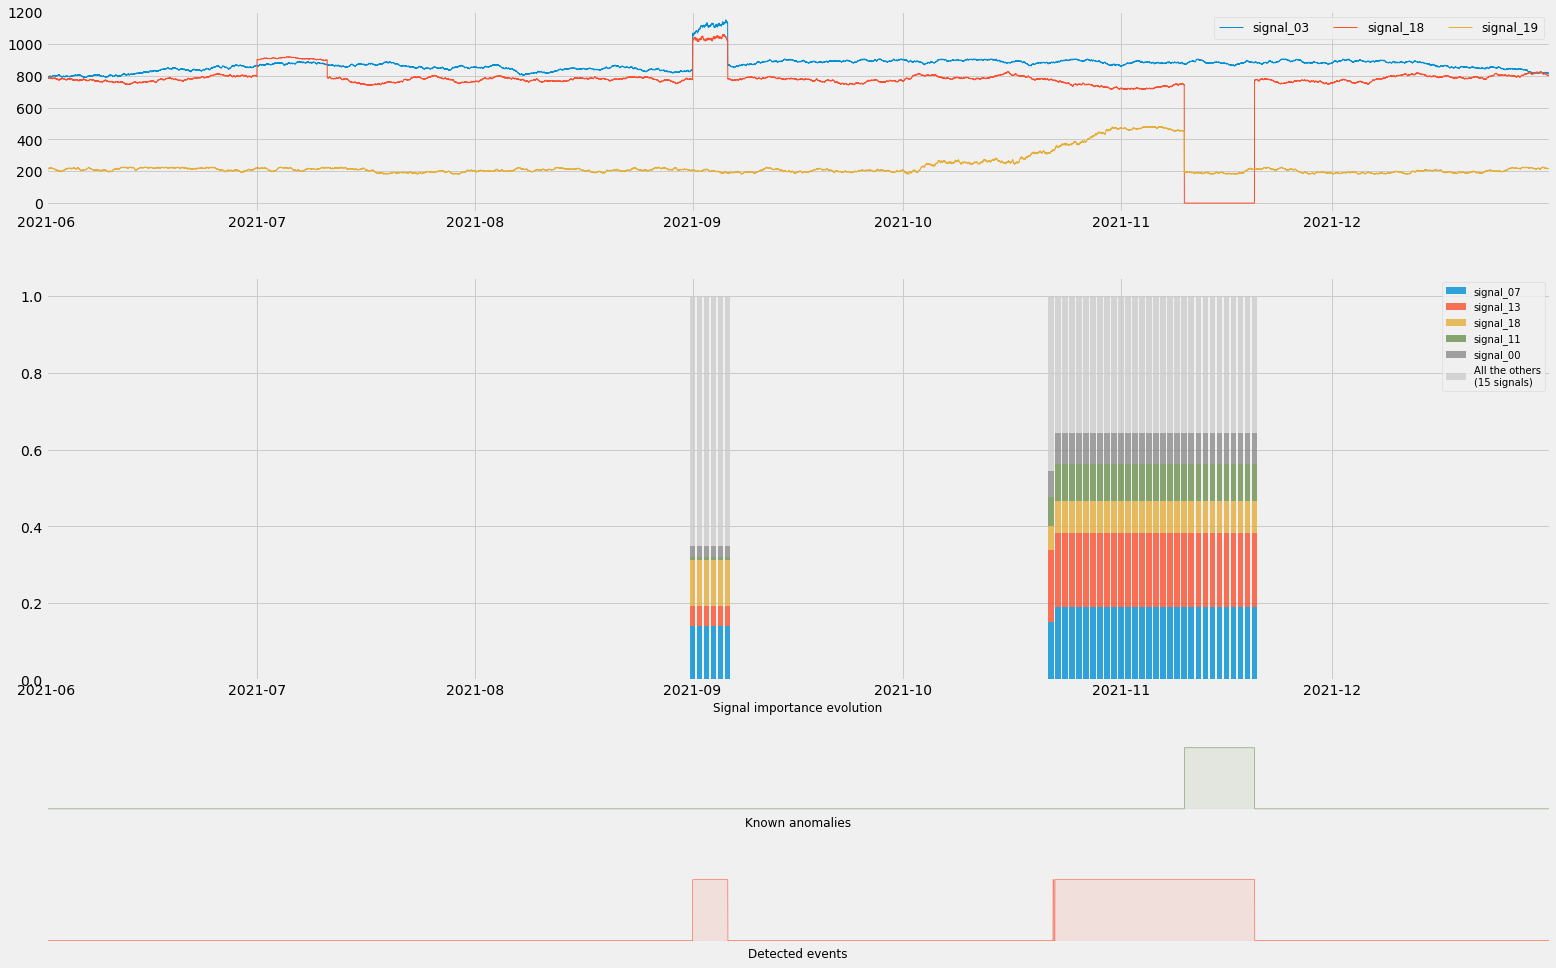

In [17]:
fig = plt.figure(figsize=(24,16))
gs = GridSpec(nrows=4, ncols=1, height_ratios=[0.3, 0.6, 0.1, 0.1], hspace=0.35)

ax0 = fig.add_subplot(gs[0])
for tag in [tags_list[3], tags_list[18], tags_list[19]]:
    ax0.plot(all_tags_df.loc[plot_start:plot_end, tag], linewidth=1.0, label=tag)
ax0.legend(loc='upper right', fontsize=12, ncol=3)
ax0.set_xlim((plot_start, plot_end))

num_top_signals = 5
ax1 = fig.add_subplot(gs[1])
bottom_values = np.zeros((len(df.index),))
current_tags_list = list(df.sum().sort_values(ascending=False).head(num_top_signals).index)
for tag in current_tags_list:
    plt.bar(x=df.index, height=df[tag], bottom=bottom_values, alpha=0.8, width=bar_width, label=tag.split('\\')[0])
    bottom_values += df[tag].values

all_other_tags = [t for t in df.columns if t not in current_tags_list]
all_other_tags_contrib = df[all_other_tags].sum(axis='columns')
plt.bar(x=df.index, height=all_other_tags_contrib, bottom=bottom_values, alpha=0.8, width=bar_width, label=f'All the others\n({len(all_other_tags)} signals)', color='#CCCCCC')

ax1.legend(loc='upper right', ncol=1)
ax1.set_xlabel('Signal importance evolution', fontsize=12)
ax1.set_xlim((plot_start, plot_end))

ax2 = fig.add_subplot(gs[2])
labels_df = TSViz._convert_ranges(labeled_range, default_freq='5min')
plot_ranges(labels_df, 'Known anomalies', colors[3], ax2)
ax2.set_xlim((plot_start, plot_end))

ax3 = fig.add_subplot(gs[3])
plot_ranges(predictions_df, 'Detected events', colors[1], ax3)
ax3.set_xlim((plot_start, plot_end))

plt.show()

## Conclusion
---
In this notebook, you extracted the raw results from the anomaly detection model you trained previously and experimented with a few post-processing techniques to get more insights from your model results.